# RL Source Step Parameter Study

## Run

In [ ]:
%%bash
mkdir logs
TOP=${TOP:-$(git rev-parse --show-toplevel)}
${TOP}/build/Examples/Cxx/DP_EMT_RL_SourceStep

## Evaluation - Voltage Step

In [390]:
import villas.dataprocessing.readtools as rt
from villas.dataprocessing.timeseries import TimeSeries as ts
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

In [391]:
def calc_dpsim_variable_timestep_mae(ref, test_list):
    # find the minimum number of time steps available in the list of timeseries results
    min_length = ref.values.shape[0]
    for test in test_list:
        if test.values.shape[0] < min_length:
            min_length = test.values.shape[0]
            
    # calculate maximum amplitude of EMT reference signal to normalize error
    max_amp = np.max(np.abs(ref.values[:min_length]))

    # Calculate difference for each timeseries with respect to the 50µs reference
    diff_list = []
    for test in test_list:
        diff_list.append( (test.values[:min_length] - ref.values[:min_length]) )#/ max_amp )

    # calculate mean absolute error
    mae = []
    for diff in diff_list:
        mae.append( np.sum(np.abs(diff)) / min_length )
        
    return mae, diff_list

In [392]:
def calc_mae_dp(pd_ref, pd_test, max_step=11):
    mae_dp_list = []

    for load_idx in range(1,max_step): 
        pd_test_list = pd_test.query('timestep > 1 and step=='+str(load_idx))
        test_list = []
        for index, row in pd_test_list.iterrows():
            test_list.append(row['values']['v3_intpl_shift'])

        ref = pd_ref.query('timestep == 1 and step=='+str(load_idx)).iloc[0]['values']['v3_shift']
        mae_dp, diff_list = calc_dpsim_variable_timestep_mae(ref, test_list)
        mae_dp_list.append(mae_dp)
    
    return mae_dp_list

In [393]:
def calc_mae_dp_no_step(pd_ref, pd_test):
    pd_test_list = pd_test.query('timestep > 1')
    test_list = []
    for index, row in pd_test_list.iterrows():
        test_list.append(row['values']['v3_intpl_shift'])

    ref = pd_ref.query('timestep == 1').iloc[0]['values']['v3_shift']
    mae_dp, diff_list = calc_dpsim_variable_timestep_mae(ref, test_list)
     
    return mae_dp

In [394]:
def calc_mae_emt(pd_ref, pd_test, max_step=11):
    mae_emt_list = []

    for load_idx in range(1,max_step): 
        pd_test_list = pd_test.query('timestep > 1 and step=='+str(load_idx))
        test_list = []
        for index, row in pd_test_list.iterrows():
            test_list.append(row['values']['v3_intpl'])

        ref = pd_ref.query('timestep == 1 and step=='+str(load_idx)).iloc[0]['values']['v3']
        mae, diff_list = calc_dpsim_variable_timestep_mae(ref, test_list)
        mae_emt_list.append(mae)
        
    return mae_emt_list

In [395]:
def calc_mae_emt_no_step(pd_ref, pd_test):    
    pd_test_list = pd_test.query('timestep > 1')
    test_list = []
    for index, row in pd_test_list.iterrows():
        test_list.append(row['values']['v3_intpl'])

    ref = pd_ref.query('timestep == 1').iloc[0]['values']['v3']
    mae, diff_list = calc_dpsim_variable_timestep_mae(ref, test_list)
          
    return mae

### DP Results

In [396]:
%%capture
result_list = []
for ts_idx in range(1,21):
    logs_dir = '../../../logs_source_step/'
    log_name = logs_dir+'DP_RL_SourceStep_T' + str(ts_idx) + '/' \
            'DP_RL_SourceStep_T' + str(ts_idx)

    ts_curr = rt.read_timeseries_dpsim(log_name + '.csv')
    if ts_idx > 1:
        ts_curr = ts.interpolate_list(ts_curr, 0.00005)
    ts_curr = ts.frequency_shift_list(ts_curr, 50)
    result_list.append({'timestep': ts_idx, 'values': ts_curr})      
        
pd_dp_1 = pd.DataFrame(result_list)

result_list = []
for ts_idx in range(40,401,20):
    logs_dir = '../../../logs_source_step/'
    log_name = logs_dir+'DP_RL_SourceStep_T' + str(ts_idx) + '/' \
            'DP_RL_SourceStep_T' + str(ts_idx)

    ts_curr = rt.read_timeseries_dpsim(log_name + '.csv')
    if ts_idx > 1:
        ts_curr = ts.interpolate_list(ts_curr, 0.00005)
    ts_curr = ts.frequency_shift_list(ts_curr, 50)
    result_list.append({'timestep': ts_idx, 'values': ts_curr})      
        
pd_dp_2 = pd.DataFrame(result_list)

In [397]:
%%capture
result_list = []
for ts_idx in range(1,21):
    for load_idx in range(1,11):
        logs_dir = '../../../logs_source_step/'
        log_name = logs_dir+'DP_RL_SourceStep_T' + str(ts_idx) + '_V' + str(load_idx) + '/' \
                'DP_RL_SourceStep_T' + str(ts_idx) + '_V' + str(load_idx)
    
        ts_curr = rt.read_timeseries_dpsim(log_name + '.csv')
        if ts_idx > 1:
            ts_curr = ts.interpolate_list(ts_curr, 0.00005)
        ts_curr = ts.frequency_shift_list(ts_curr, 50)
        result_list.append({'timestep': ts_idx, 'step': load_idx, 'values': ts_curr})      
        
pd_dp_vstep_1 = pd.DataFrame(result_list)

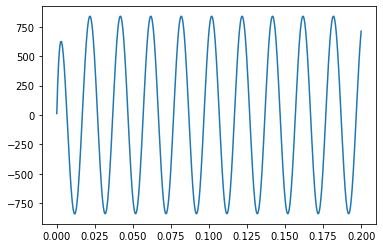

In [398]:
curr = pd_dp_1.query('timestep=='+str(1))['values'].values[0]
plt.plot(curr['v3_shift'].time, curr['v3_shift'].values)

In [399]:
nom_amp = max(curr['v3_shift'].values)

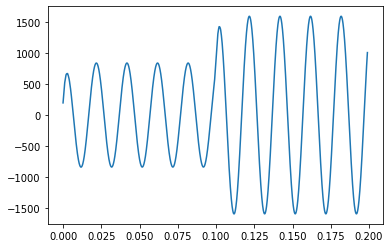

In [400]:
sourcestep = 9
timestep = 20
curr = pd_dp_vstep_1.query('timestep=='+str(timestep)+' and step=='+str(sourcestep))['values'].values[0]
plt.plot(curr['v3_intpl_shift'].time, curr['v3_intpl_shift'].values)

In [401]:
mae_dp_list_1 = calc_mae_dp(pd_dp_vstep_1, pd_dp_vstep_1)

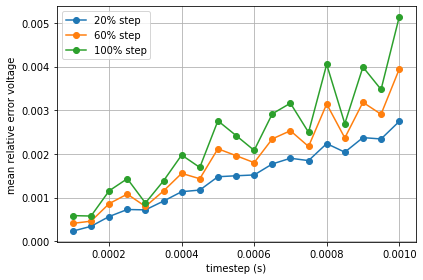

In [402]:
import matplotlib.ticker as ticker
ax = plt.figure().gca()
ax.xaxis.set_major_locator(ticker.MultipleLocator(0.0002))

timesteps = np.arange(2,21)*0.00005
for load_idx in range(1,10,4):  
    plt.plot(timesteps, mae_dp_list_1[load_idx] / nom_amp, 'o-', label=str(load_idx*10+10)+'% step')
#plt.ylim([-0.01,0.2])
#plt.xlim([0,0.0009])

plt.xlabel('timestep (s)')
plt.ylabel('mean relative error voltage')
plt.grid()
plt.legend()
plt.tight_layout()
plt.savefig('dp_rl_source_step_voltage_1ms.pdf')

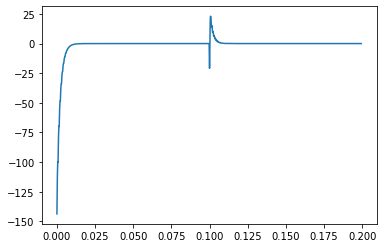

In [403]:
sourcestep = 4
timestep = 15
curr = pd_dp_vstep_1.query('timestep=='+str(1)+' and step=='+str(sourcestep))['values'].values[0]
curr_vts = pd_dp_vstep_1.query('timestep=='+str(timestep)+' and step=='+str(sourcestep))['values'].values[0]
min_len = min(curr['v3_shift'].values.shape, curr_vts['v3_intpl_shift'].values.shape)[0]
plt.plot(curr['v3_shift'].time[:min_len], curr['v3_shift'].values[:min_len] - curr_vts['v3_intpl_shift'].values[:min_len])

In [404]:
%%capture
result_list = []
for ts_idx in range(40,401,20):
    for load_idx in range(1,11):
        logs_dir = '../../../logs_source_step/'
        log_name = logs_dir+'DP_RL_SourceStep_T' + str(ts_idx) + '_V' + str(load_idx) + '/' \
            'DP_RL_SourceStep_T' + str(ts_idx) + '_V' + str(load_idx)
    
        ts_curr = rt.read_timeseries_dpsim(log_name + '.csv')
        if ts_idx > 1:
            ts_curr = ts.interpolate_list(ts_curr, 0.00005)
        ts_curr = ts.frequency_shift_list(ts_curr, 50)
        result_list.append({'timestep': ts_idx, 'step': load_idx, 'values': ts_curr})      
        
pd_dp_vstep_2 = pd.DataFrame(result_list)

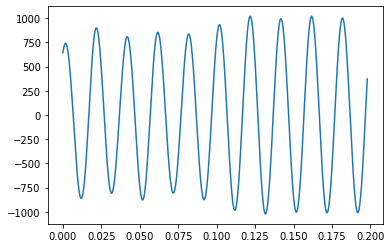

In [405]:
sourcestep = 2
timestep = 360
curr = pd_dp_vstep_2.query('timestep=='+str(timestep)+' and step=='+str(sourcestep))['values'].values[0]
plt.plot(curr['v3_intpl_shift'].time, curr['v3_intpl_shift'].values)

In [406]:
mae_dp_list_2 = calc_mae_dp(pd_dp_vstep_1, pd_dp_vstep_2)

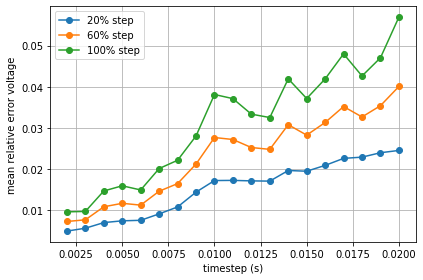

In [407]:
timesteps = np.arange(40,401,20)*0.00005
for load_idx in range(1,10,4):  
    plt.plot(timesteps, mae_dp_list_2[load_idx] / nom_amp, 'o-', label=str(load_idx*10+10)+'% step')
#plt.ylim([-0.01,0.2])
#plt.xlim([0,0.0009])

plt.xlabel('timestep (s)')
plt.ylabel('mean relative error voltage')
plt.grid()
plt.legend()
plt.tight_layout()
plt.savefig('dp_rl_source_step_voltage_20ms.pdf')

### EMT Results

In [408]:
%%capture
result_list = []
for ts_idx in range(1,21):
    logs_dir = '../../../logs_source_step/'
    log_name = logs_dir+'EMT_RL_SourceStep_T' + str(ts_idx) + '/' \
            'EMT_RL_SourceStep_T' + str(ts_idx)

    ts_curr = rt.read_timeseries_dpsim(log_name + '.csv')
    if ts_idx > 1:
        ts_curr = ts.interpolate_list(ts_curr, 0.00005)
    result_list.append({'timestep': ts_idx, 'values': ts_curr})      
        
pd_emt_1 = pd.DataFrame(result_list)

result_list = []
for ts_idx in range(40,401,20):
    logs_dir = '../../../logs_source_step/'
    log_name = logs_dir+'EMT_RL_SourceStep_T' + str(ts_idx) + '/' \
            'EMT_RL_SourceStep_T' + str(ts_idx)

    ts_curr = rt.read_timeseries_dpsim(log_name + '.csv')
    if ts_idx > 1:
        ts_curr = ts.interpolate_list(ts_curr, 0.00005)
    result_list.append({'timestep': ts_idx, 'values': ts_curr})      
        
pd_emt_2 = pd.DataFrame(result_list)

In [409]:
%%capture
result_list = []
for ts_idx in range(1,21):
    for load_idx in range(1,11):
        logs_dir = '../../../logs_source_step/'
        log_name = logs_dir+'EMT_RL_SourceStep_T' + str(ts_idx) + '_V' + str(load_idx) + '/' \
            'EMT_RL_SourceStep_T' + str(ts_idx) + '_V' + str(load_idx)
    
        ts_curr = rt.read_timeseries_dpsim(log_name + '.csv')
        if ts_idx > 1:
            ts_curr = ts.interpolate_list(ts_curr, 0.00005)
        result_list.append({'timestep': ts_idx, 'step': load_idx, 'values': ts_curr})      
        
pd_emt_vstep_1 = pd.DataFrame(result_list)

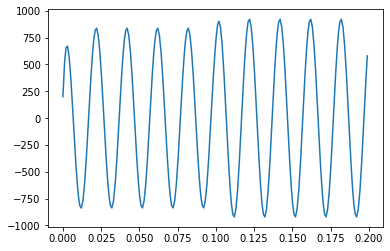

In [410]:
sourcestep = 1
timestep = 20
curr = pd_emt_vstep_1.query('timestep=='+str(timestep)+' and step=='+str(sourcestep))['values'].values[0]
plt.plot(curr['v3_intpl'].time, curr['v3_intpl'].values)

In [411]:
mae_emt_list_1 = calc_mae_emt(pd_emt_vstep_1, pd_emt_vstep_1)

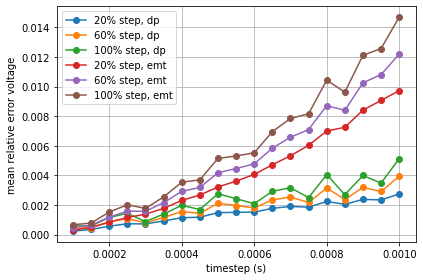

In [412]:
timesteps = np.arange(2,21)*0.00005

for i in range(1,10,4):  
    plt.plot(timesteps, mae_dp_list_1[i] / nom_amp, 'o-', label=str(i*10+10)+'% step, dp')
for i in range(1,10,4):  
    plt.plot(timesteps, mae_emt_list_1[i] / nom_amp, 'o-', label=str(i*10+10)+'% step, emt')

#plt.ylim([-0.01,0.2])
#plt.xlim([0,0.0009])

plt.xlabel('timestep (s)')
plt.ylabel('mean relative error voltage')
plt.grid()
plt.legend()
plt.tight_layout()
plt.savefig('dp_emt_rl_source_step_voltage_1ms.pdf')

In [413]:
%%capture
result_list = []
for ts_idx in range(40,401,20):
    for load_idx in range(1,11):
        log_dir = '../../../logs_source_step/'
        log_name = log_dir + 'EMT_RL_SourceStep_T' + str(ts_idx) + '_V' + str(load_idx) + '/' \
                    'EMT_RL_SourceStep_T' + str(ts_idx) + '_V' + str(load_idx)    
        ts_curr = rt.read_timeseries_dpsim(log_name + '.csv')
        if ts_idx > 1:
            ts_curr = ts.interpolate_list(ts_curr, 0.00005)
        result_list.append({'timestep': ts_idx, 'step': load_idx, 'values': ts_curr})      
        
pd_emt_vstep_2 = pd.DataFrame(result_list)

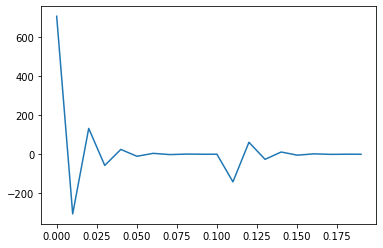

In [414]:
sourcestep = 2
timestep = 200
curr = pd_emt_vstep_2.query('timestep=='+str(timestep)+' and step=='+str(sourcestep))['values'].values[0]
plt.plot(curr['v3_intpl'].time, curr['v3_intpl'].values)

In [415]:
mae_emt_list_2 = calc_mae_emt(pd_emt_vstep_1, pd_emt_vstep_2)

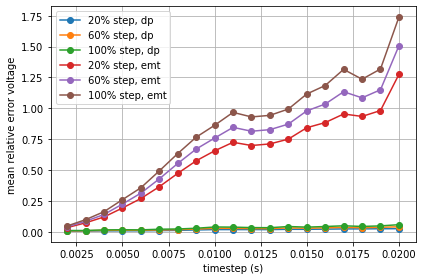

In [434]:
timesteps = np.arange(40,401,20)*0.00005

for load_idx in range(1,10,4):  
    plt.plot(timesteps, mae_dp_list_2[load_idx] / nom_amp, 'o-', label=str(load_idx*10+10)+'% step, dp')

for load_idx in range(1,10,4):  
    plt.plot(timesteps, mae_emt_list_2[load_idx] / nom_amp, 'o-', label=str(load_idx*10+10)+'% step, emt')

#plt.ylim([0,0.1])
plt.xlabel('timestep (s)')
plt.ylabel('mean relative error voltage')
plt.grid()
plt.legend()
plt.tight_layout()
plt.savefig('dp_emt_rl_source_step_voltage_20ms.pdf')

## Evaluation - Frequency Step

### DP Results

In [417]:
%%capture
result_list = []
for ts_idx in range(1,21):
    for load_idx in range(1,11):
        log_dir = '../../../logs_source_step/'
        log_name = log_dir + 'DP_RL_SourceStep_T' + str(ts_idx) + '_F' + str(load_idx) + '/' \
                    'DP_RL_SourceStep_T' + str(ts_idx) + '_F' + str(load_idx)

        ts_curr = rt.read_timeseries_dpsim(log_name + '.csv')
        if ts_idx > 1:
            ts_curr = ts.interpolate_list(ts_curr, 0.00005)
        ts_curr = ts.frequency_shift_list(ts_curr, 50)
        result_list.append({'timestep': ts_idx, 'step': load_idx, 'values': ts_curr})      
        
pd_dp_fstep_1 = pd.DataFrame(result_list)

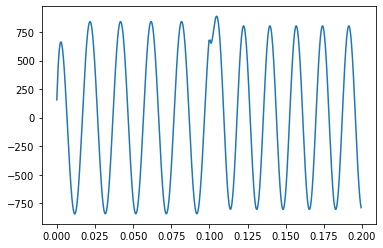

In [418]:
sourcestep = 8
timestep = 15
curr = pd_dp_fstep_1.query('timestep=='+str(timestep)+' and step=='+str(sourcestep))['values'].values[0]
plt.plot(curr['v3_intpl_shift'].time, curr['v3_intpl_shift'].values)

In [419]:
mae_dp_fstep_1 = calc_mae_dp(pd_dp_fstep_1, pd_dp_fstep_1)
mae_dp_1 = calc_mae_dp_no_step(pd_dp_1, pd_dp_1)

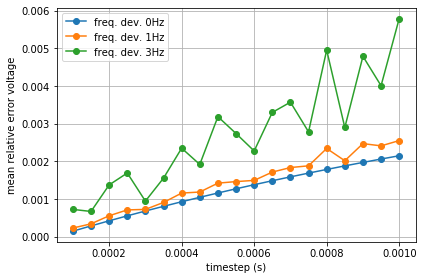

In [432]:
timesteps = np.arange(2,21)*0.00005
plt.plot(timesteps, mae_dp_1 / nom_amp, 'o-', label='freq. dev. 0Hz')
for i in range(0,4,2):   
    plt.plot(timesteps, mae_dp_fstep_1[i] / nom_amp, 'o-', label='freq. dev. '+str(i+1)+'Hz')

plt.xlabel('timestep (s)')
plt.ylabel('mean relative error voltage')
plt.grid()
plt.legend()
plt.tight_layout()
plt.savefig('dp_rl_source_step_frequency_1ms.pdf')

In [421]:
%%capture
result_list = []
for ts_idx in range(40,401,20):
    for load_idx in range(1,11):
        log_dir = '../../../logs_source_step/'
        log_name = log_dir + 'DP_RL_SourceStep_T' + str(ts_idx) + '_F' + str(load_idx) + '/' \
                   'DP_RL_SourceStep_T' + str(ts_idx) + '_F' + str(load_idx)
    
        ts_curr = rt.read_timeseries_dpsim(log_name + '.csv')
        if ts_idx > 1:
            ts_curr = ts.interpolate_list(ts_curr, 0.00005)
        ts_curr = ts.frequency_shift_list(ts_curr, 50)
        result_list.append({'timestep': ts_idx, 'step': load_idx, 'values': ts_curr})      
        
pd_dp_fstep_2 = pd.DataFrame(result_list)

In [422]:
mae_dp_fstep_2 = calc_mae_dp(pd_dp_fstep_1, pd_dp_fstep_2)
mae_dp_2 = calc_mae_dp_no_step(pd_dp_1, pd_dp_2)

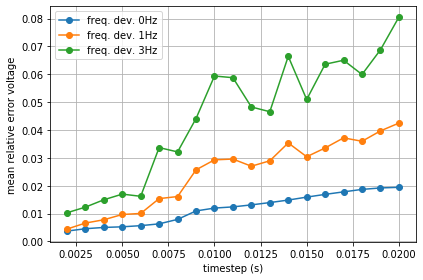

In [423]:
timesteps = np.arange(40,401,20)*0.00005
plt.plot(timesteps, mae_dp_2 / nom_amp, 'o-', label='freq. dev. 0Hz')
for i in range(0,4,2):   
    plt.plot(timesteps, mae_dp_fstep_2[i] / nom_amp, 'o-', label='freq. dev. '+str(i+1)+'Hz')

plt.xlabel('timestep (s)')
plt.ylabel('mean relative error voltage')
plt.grid()
plt.legend()
plt.tight_layout()
plt.savefig('dp_rl_source_step_frequency_20ms.pdf')

### EMT Results

In [424]:
%%capture
result_list = []
for ts_idx in range(1,21):
    for load_idx in range(1,11):
        log_dir = '../../../logs_source_step/'
        log_name = log_dir + 'EMT_RL_SourceStep_T' + str(ts_idx) + '_F' + str(load_idx) + '/' \
            'EMT_RL_SourceStep_T' + str(ts_idx) + '_F' + str(load_idx)
    
        ts_curr = rt.read_timeseries_dpsim(log_name + '.csv')
        if ts_idx > 1:
            ts_curr = ts.interpolate_list(ts_curr, 0.00005)
        result_list.append({'timestep': ts_idx, 'step': load_idx, 'values': ts_curr})      
        
pd_emt_fstep_1 = pd.DataFrame(result_list)

In [425]:
mae_emt_fstep_1 = calc_mae_emt(pd_emt_fstep_1, pd_emt_fstep_1)
mae_emt_1 = calc_mae_emt_no_step(pd_emt_1, pd_emt_1)

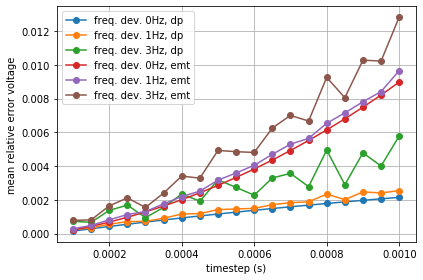

In [436]:
timesteps = np.arange(2,21)*0.00005

plt.plot(timesteps, mae_dp_1 / nom_amp, 'o-', label='freq. dev. 0Hz, dp')
for i in range(0,4,2):  
    plt.plot(timesteps, mae_dp_fstep_1[i] / nom_amp, 'o-', label='freq. dev. '+str(i+1)+'Hz, dp')

plt.plot(timesteps, mae_emt_1 / nom_amp, 'o-', label='freq. dev. 0Hz, emt')
for i in range(0,4,2):    
    plt.plot(timesteps, mae_emt_fstep_1[i] / nom_amp, 'o-', label='freq. dev. '+str(i+1)+'Hz, emt')

plt.xlabel('timestep (s)')
plt.ylabel('mean relative error voltage')
plt.grid()
plt.legend()
plt.tight_layout()
plt.savefig('dp_emt_rl_source_step_frequency_1ms.pdf')

In [427]:
%%capture
result_list = []
for ts_idx in range(40,401,20):
    for load_idx in range(1,11):
        log_dir = '../../../logs_source_step/'
        log_name = log_dir+'EMT_RL_SourceStep_T' + str(ts_idx) + '_F' + str(load_idx) + '/' \
            'EMT_RL_SourceStep_T' + str(ts_idx) + '_F' + str(load_idx)
    
        ts_curr = rt.read_timeseries_dpsim(log_name + '.csv')
        if ts_idx > 1:
            ts_curr = ts.interpolate_list(ts_curr, 0.00005)
        result_list.append({'timestep': ts_idx, 'step': load_idx, 'values': ts_curr})      
        
pd_emt_fstep_2 = pd.DataFrame(result_list)

In [428]:
mae_emt_fstep_2 = calc_mae_emt(pd_emt_fstep_1, pd_emt_fstep_2)
mae_emt_2 = calc_mae_emt_no_step(pd_emt_1, pd_emt_2)

In [ ]:
timesteps = np.arange(40,401,20)*0.00005

plt.plot(timesteps, mae_dp_2 / nom_amp, 'o-', label='freq. dev. 0Hz, dp')
for i in range(0,4,2):  
    plt.plot(timesteps, mae_dp_fstep_2[i] / nom_amp, 'o-', label='freq. dev. '+str(i+1)+'Hz, dp')

plt.plot(timesteps, mae_emt_2 / nom_amp, 'o-', label='freq. dev. 0Hz, emt')
for i in range(0,4,2):  
    plt.plot(timesteps, mae_emt_fstep_2[i] / nom_amp, 'o-', label='freq. dev. '+str(i+1)+'Hz, emt')
    
#plt.xlim([0.0015,0.008])
#plt.ylim([0,400])
#plt.ylim([0,0.1])
plt.xlabel('timestep (s)')
plt.ylabel('mean relative error voltage')
plt.grid()
plt.legend()
plt.tight_layout()
plt.savefig('dp_emt_rl_source_step_frequency_20ms.pdf')